In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
from pathlib import Path
from fastai.callbacks import *

In [2]:
path = Path('/home/jupyter/shopee/data')
bs = 128

# Language Model for Text 

## data_lm

In [5]:
df = pd.read_csv(path/'mobile_lm_train.csv')
df.tail()

,title
200742,nokia 5.1 plus ram 3gb 32gb garansi resmi 1 ta...
200743,big promo add whatshap 0821 9127 5399 iphone 7...
200744,datang lagi sharp r1 ram 3gb 32gb gratis silic...
200745,sony xperia z5 premium au ram 3gb rom 32gb sec...
200746,xiaomi mi 8 ram 6 128gb black


In [6]:
data_lm = (TextList.from_csv(path, 'mobile_lm_train.csv', cols='title')
                   .split_by_rand_pct(0.2)
                   .label_for_lm() 
                   .databunch(bs=bs))

In [7]:
data_lm.save('mobile_data_lm_awd_230319.pkl')

## load old data_lm

In [9]:
data_lm = load_data(path, 'mobile_data_lm_awd_230319.pkl', bs=bs)

In [10]:
data_lm.show_batch()

idx,text
0,samsung galaxy j1 mini sm j105 8 gb white xxbos iphone 5 white 16 gb fullset mulus xxbos lenovo a 6000 se 1 16 white xxbos keypad blackberry 9360 hitam xxbos xiaomi redmi 3pro 3s xxbos iphone 6s 64 gb xxbos iphone 5 garansi 1 thn platinum xxbos iphone 5s 32 gb xxbos iphone 4s 16 gb black baru garansi 1 tahun xxbos nokia 230 garansi resmi 1 tahun
1,6 6s 3d full cover tempered glass white xxbos wa 081244968245 brandcode b230 dual sim kamera suara super xxbos promo sale cuci gudang beli 2 gratis 1 vivo v5 garansi resmi perfect selfie murah xxbos xxunk 256 gb space gray xxbos honor 8 pro ram 6 gb internal 64 gb istimewa jarang ada yg punya xxbos doogee s60 lite fullblack xxbos promo spesial beli 2 bonus 1 iphone 6
2,gb black matte xxbos iphone 5 32 gb white second ex grs internasional xxbos samsung galaxy a5 xxbos handphone outdoor powerbank 12800mah brandcode b81 plus 3 gsm lcd 2.4 inch fm radio camera xxbos samsung guru music sm b310e biru xxbos xiaomi redmi note4 3 32 snapdragon xxbos strawberry st22 xxbos oppo f1s edition black original xxbos vivo v5s bonus pb xxbos casing nokia asha 106 107 hitam xxbos
3,wa ke o83l 3625 3737 vivo v9 fullset seken rasa baru mulus 100 ram 4 64 gb xxbos oppo a83 2 gb xxbos oppo f7 ram 4 gb 64 gb xxbos promo terbatas minat chat di wa 085932905001 oppo f7 64 gb xxbos unix lcd 1set samsung a310 a310f xxunk galaxy a3 2016 original oem black xxbos promo khusus hari ini beli 2 gratis 1 samsung galaxy j4 smartphone
4,xiaomi mi mix 256 gb xxbos whatsapp 0831 3756 1979 big promo lg stylus 2 k520dy 4 g lte dual sim ram 2 gb xxbos xiaomi mi a1 4 64 red baru new grs resmi tam bl xxunk xxbos ready stock 00 h3 samsung galaxy s8 xxbos big promo oppo f5 red xxbos minat serius wa 082260538997 beli 2 grtis 1 iphone 5s 16 gb silver ex inter mulus


## train language model

In [11]:
learn = language_model_learner(data_lm, AWD_LSTM, wd =0.1, drop_mult=0.8)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


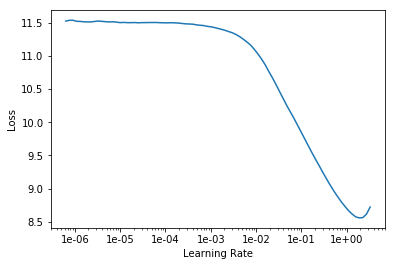

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(1,1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.828648,3.320309,0.358419,00:23


In [14]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


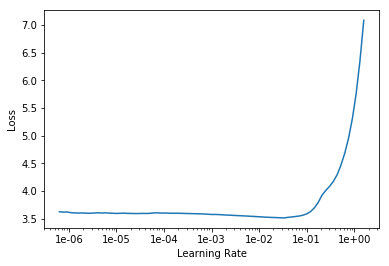

In [15]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,3.183770,2.931540,0.399575,00:28
1,2.942456,2.753628,0.418633,00:28
2,2.829986,2.723087,0.420417,00:28
3,2.866560,2.725773,0.420385,00:28
4,2.818741,2.686595,0.423702,00:28
5,2.729988,2.639767,0.427484,00:28
6,2.708273,2.598531,0.433096,00:28
7,2.627986,2.538106,0.441875,00:28
8,2.531823,2.487841,0.449131,00:28
9,2.505339,2.457415,0.454911,00:28


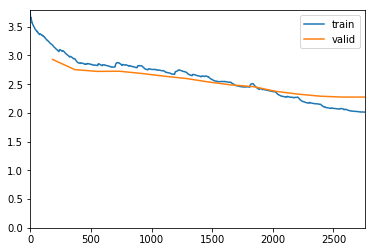

/opt/anaconda3/lib/python3.7/site-packages/fastai/callbacks/tracker.py:48: UserWarning: <class 'fastai.callbacks.tracker.SaveModelCallback'> conditioned on metric `error_rate` which is not available. Available metrics are: train_loss, valid_loss, accuracy, time
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')
/opt/anaconda3/lib/python3.7/site-packages/fastai/callbacks/tracker.py:48: UserWarning: <class 'fastai.callbacks.tracker.SaveModelCallback'> conditioned on metric `error_rate` which is not available. Available metrics are: train_loss, valid_loss, accuracy, time
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')
/opt/anaconda3/lib/python3.7/site-packages/fastai/callbacks/tracker.py:48: UserWarning: <class 'fastai.callbacks.tracker.SaveModelCallback'> c

In [17]:
learn.fit_one_cycle(15,3e-2, moms=(0.8,0.7),
                   callbacks=[ShowGraph(learn),SaveModelCallback(learn,monitor='error_rate',mode='min')])

In [18]:
learn.save('fine_tuned_awd_mobile_230319')
learn.save_encoder('fine_tuned_lstm_enc_awd_mobile_230319')

In [23]:
TEXT = "iphone"
N_WORDS = 7
N_SENTENCES = 5
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

iphone 7 plus 128 gb black xxbos promo
iphone 5s 32 gb gold seken second xxbos
iphone 6 plus 16 gb gold xxbos iphone
iphone 6 plus 64 gb silver second ori
iphone 7 32 gb black matte xxbos promo


# Text Classifier

## data_clas

In [25]:
df = pd.read_csv(path/'mobile_train_v3_sss.csv')
df.head()

,itemid,title,Category,image_path,Type,Actual,Predicted,Correct,is_valid
0,831916856,diskon order hub wa 08 13 437 761 77 jual ipho...,31,mobile_image/91d02789527780b4b0d49aebf0965002.jpg,Mobile,Iphone,Iphone,True,False
1,1213149579,diskon baterai samsung s6310 young 2 galaxy ac...,32,mobile_image/ea7494f01e52766d1cf9884cd588fcec.jpg,Mobile,Samsung,Samsung,True,False
2,1322992490,vivo y71 ram 2gb,42,mobile_image/bb1d521e858fae98bc2d1932108cc2d9.jpg,Mobile,Vivo,Vivo,True,False
3,1097073314,xiaomi redmi 4x 3 in 1 topk asli anti mengetuk...,34,mobile_image/a526836f00eb04fedafd9e89d88be391.jpg,Mobile,Xiaomi,Xiaomi,True,False
4,1588982229,iphone x 256 silver,31,mobile_image/0a509643f51c63344beba4e7ced20fa2.jpg,Mobile,Iphone,Iphone,True,False


In [72]:
bs = 256

In [73]:
data_clas = (TextList.from_df(df , cols='title', vocab = data_lm.vocab)
             .split_from_df(col='is_valid')
             .label_from_df(cols='Category')
             .databunch(bs=bs))

In [28]:
data_clas.save(path/'data_clas_mobile_awd_230319.pkl')

In [75]:
data_clas.show_batch()

text,target
xxbos wa 62 831 3631 579 promo beli 2 gratis 1 oukitel k1 xxrep 4 0 max 1 xxrep 4 0 mah 3 gb 32 gb android 7 ip68,33
xxbos beli 2 gratis 1 promo cuci gudang wa.0831425 xxrep 4 1 5 new vivo y71 ram 3 gb rom 32 gb resmi,42
xxbos minat chat wa 0831 3800 7445 xiomi 4x big promo beli 2 grtis 1 xxunk power bank slim 1 xxrep 4 0,34
xxbos for samsung galaxy j1 j2 j3 j5 j7 2015 2016 a3 a5 a7 2017 prime ace pro macan 3d bear line,32
xxbos cuci gudang sale asus rog gl553ve gl503vd core i7 1050ti 16 gb ssd 256 gb 1 tb w10 wa o83i 3612,35


## load old data_clas

In [74]:
data_clas = load_data(path,'data_clas_mobile_awd_230319.pkl',bs=bs)

## train text classifer

In [132]:
from fastai.metrics import *

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult= 0.7,wd=0.01)
learn.load_encoder('fine_tuned_lstm_enc_awd_mobile_230319')

In [133]:
learn.metrics=[accuracy,
               Precision(average='weighted'),
               Recall(average='weighted'),
               FBeta(average='weighted')]

In [118]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


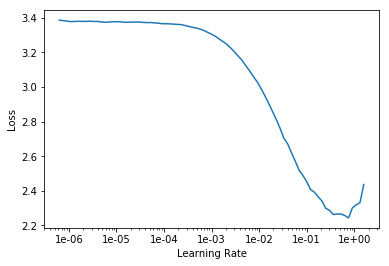

In [119]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 3e-01, moms=(0.8,0.7))

In [121]:
learn.save('fit_head')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


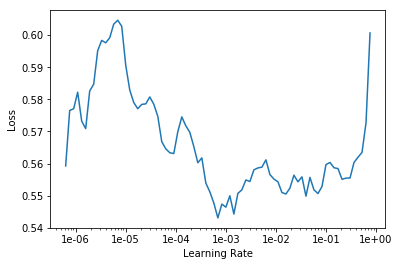

In [124]:
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot()

In [125]:
learn.fit_one_cycle(1, slice(3e-02/(2.6**4),3e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
0,0.428825,0.387990,0.885057,0.883083,0.885057,0.882596,00:15


In [126]:
learn.save('second')

In [134]:
learn.load('second');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


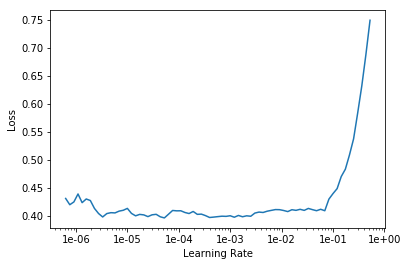

In [135]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot()

In [136]:
learn.fit_one_cycle(1, slice(5e-02/(2.6**4),5e-02), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
0,0.411064,0.372371,0.890826,0.889482,0.890826,0.888853,00:22


In [137]:
learn.save('third')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


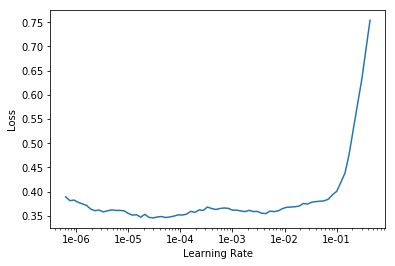

In [138]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
0,0.367021,0.368545,0.891892,0.890867,0.891892,0.890170,00:27
1,0.348189,0.356882,0.895184,0.894519,0.895184,0.893192,00:28
2,0.333520,0.348868,0.897253,0.897162,0.897253,0.895160,00:28
3,0.320652,0.338388,0.901235,0.900135,0.901235,0.899907,00:27
4,0.297625,0.336740,0.902960,0.902647,0.902960,0.901338,00:26
5,0.287310,0.333657,0.904998,0.903867,0.904998,0.903732,00:27
6,0.271199,0.333318,0.905688,0.904429,0.905688,0.904467,00:28
7,0.262912,0.336704,0.905938,0.905147,0.905938,0.904771,00:27
8,0.251268,0.335278,0.905750,0.904728,0.905750,0.904720,00:28
9,0.246734,0.339675,0.905719,0.904697,0.905719,0.904665,00:27


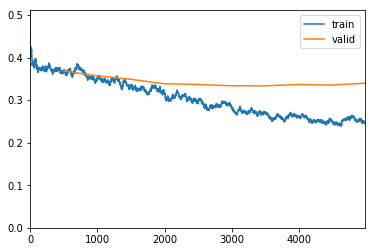

In [139]:
learn.fit_one_cycle(10, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7),
                    callbacks=[ShowGraph(learn)])

In [140]:
learn.save('mobile_text_awd_256_0.6_220319')

In [142]:
learn.validate()

[0.3396747, tensor(0.9057), tensor(0.9047), tensor(0.9057), tensor(0.9055)]

## Confusion Matrix

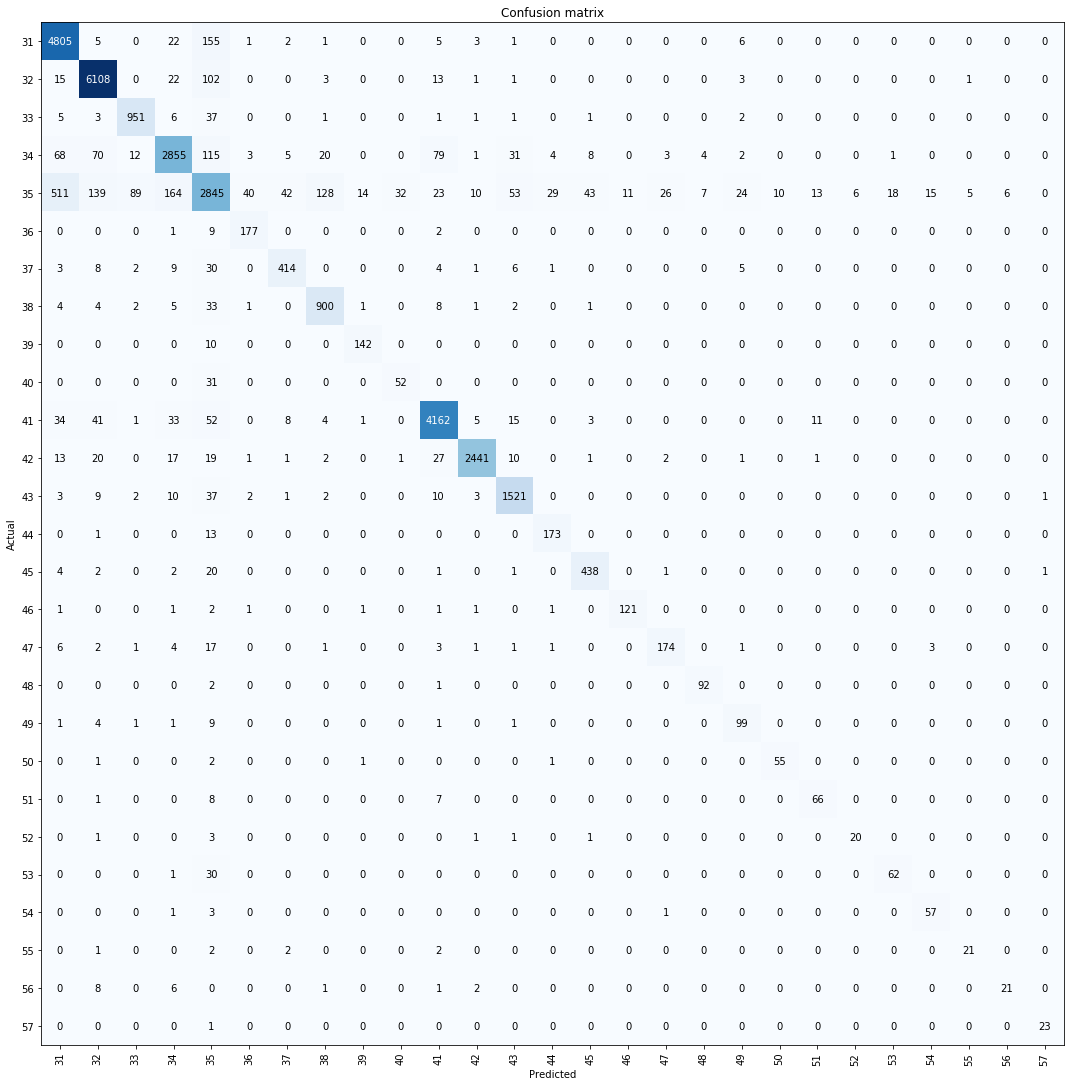

In [143]:
interp.plot_confusion_matrix(figsize=(15,15))

# Get Predictions

## load model

In [176]:
data_lm = load_data(path, 'mobile_data_lm_awd_230319.pkl', bs=128)
data_clas = load_data(path,'data_clas_mobile_awd_230319.pkl',bs=bs)

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult= 0.7,wd=0.01)
learn.load_encoder('fine_tuned_lstm_enc_awd_mobile_230319')
learn.load('mobile_text_awd_256_0.6_220319')

## add test set for predicting

In [229]:
import pandas as pd
from pathlib import Path

path = Path('/home/jupyter/shopee/data')
df = pd.read_csv(path/'mobile_train_v3_sss.csv')
df = df[df['is_valid'] == True].reset_index()

In [174]:
df.shape

(31894, 9)

In [175]:
test= TextList.from_df(df,cols='title')
data_clas.add_test(test)

In [178]:
learn.validate()

[0.3396747, tensor(0.9057)]

## generate predictions

In [179]:
preds , y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True,ordered=True)

In [230]:
df = df.drop(columns=['image_path','Type','Actual','Predicted','Correct','is_valid'])

In [231]:
df_pred = pd.DataFrame(np.asarray(preds), columns=[str(i+31) + '_lstm' for i in range(27)]).reset_index()

In [235]:
torch.argmax(preds,dim=1) +31

tensor([42, 35, 35,  ..., 38, 42, 31])

In [237]:
result = pd.concat([df, df_pred], axis=1)

In [240]:
result.drop(columns=['index'])

,itemid,title,Category,31_lstm,32_lstm,33_lstm,34_lstm,35_lstm,36_lstm,37_lstm,...,48_lstm,49_lstm,50_lstm,51_lstm,52_lstm,53_lstm,54_lstm,55_lstm,56_lstm,57_lstm
0,285735342,vivo v5,42,1.048653e-05,9.586571e-06,2.035929e-06,6.986788e-06,2.647947e-05,1.569318e-08,2.213573e-06,...,9.881019e-10,3.157522e-06,7.015986e-10,2.958142e-09,3.281743e-09,4.028206e-09,1.420636e-07,1.035822e-10,4.013003e-07,6.350449e-08
1,1685256193,diskon icheckey premium ring stand holder hp b...,35,2.608890e-03,6.435231e-04,3.174524e-04,6.277368e-04,9.950329e-01,1.392338e-05,1.845094e-04,...,2.163419e-06,8.438229e-05,1.211023e-05,2.137791e-07,1.674666e-05,4.037007e-06,4.249592e-07,1.201593e-06,9.198538e-07,1.982123e-06
2,1544415858,promo discon stock terbatas lg v30 plus dual s...,35,1.496994e-04,3.377267e-02,2.078875e-03,9.188867e-04,9.452865e-01,1.482539e-06,5.902445e-03,...,1.899009e-06,7.501545e-03,8.358455e-05,8.196061e-07,7.625183e-06,5.058098e-05,1.870163e-08,7.408109e-06,4.068517e-06,4.972905e-06
3,1213429900,murah touchscreen sony experia z3 d6653 original,33,2.702377e-05,1.585526e-05,9.532446e-01,7.995840e-04,4.476052e-02,1.808475e-05,3.112693e-05,...,2.028235e-06,3.122407e-04,1.120683e-06,8.968501e-07,7.263637e-06,1.348804e-06,2.756646e-07,6.048691e-06,5.253681e-06,2.457230e-08
4,1756878817,oppo a7 ram 4gb internal 64gb garansi resmi,41,9.191604e-06,7.418376e-05,4.305679e-05,2.309853e-03,1.600439e-04,4.326077e-07,6.235323e-05,...,2.456404e-07,7.698978e-07,1.283301e-07,2.824660e-05,6.249378e-07,9.868211e-07,3.827211e-06,8.438318e-06,1.898921e-04,8.952559e-08
5,698138585,handphone iphone 7 plus 256gb warna putih,31,9.439555e-01,4.957046e-04,1.517941e-04,7.705133e-03,3.636111e-02,1.019865e-04,2.047566e-04,...,4.293624e-06,4.837792e-05,1.156580e-05,2.425175e-05,3.260871e-06,1.038528e-04,3.046759e-04,1.064788e-04,1.161436e-04,9.490432e-06
6,410121852,iphone 6 16gb gold second ex inter original re...,31,9.304487e-01,3.867731e-05,6.209435e-05,1.622379e-03,6.658475e-02,1.648503e-05,2.263874e-04,...,6.420232e-07,2.705514e-05,1.984207e-06,1.152585e-05,1.936535e-07,1.554338e-05,5.782641e-06,1.036103e-05,1.021799e-05,1.144116e-06
7,1344090682,asus zenfone 5q zc600kl black garansi resmi,43,2.570493e-05,6.771496e-05,2.573385e-05,7.776567e-03,4.772726e-04,1.897609e-05,3.590927e-04,...,6.756651e-07,2.590886e-05,3.064912e-08,2.221909e-05,4.634369e-05,3.712326e-06,4.842980e-05,3.582784e-06,2.115702e-04,7.129879e-06
8,117013820,iphone 6 64gb gold seken ex grnsi international,31,9.523261e-01,1.538236e-04,1.651382e-04,5.088400e-03,4.021227e-02,1.633560e-05,2.224375e-04,...,7.411680e-07,6.540866e-05,2.748177e-06,9.629302e-06,7.031936e-07,1.823435e-05,1.505781e-05,1.449840e-05,2.701480e-05,1.230439e-06
9,1495793434,bestseller zyrex zs 278 dual sim garansi resmi...,35,7.111884e-06,1.264702e-04,1.042165e-06,1.025186e-04,9.996922e-01,3.471191e-09,1.255475e-06,...,7.636191e-08,4.937821e-07,1.083703e-08,2.612771e-09,1.269857e-08,5.209366e-08,1.341276e-07,7.616263e-08,1.040384e-06,5.329682e-07


In [242]:
result.to_csv('mobile_ensemble_lstm.csv', index=False)